# Approximate Predictive Control Barrier Function for a Nonlinear System
This notebook contains the simulations of the nonlinear implementation of the safety filter based on the approximation of the PCBF

In [ ]:
""" Copyright (c) 2023, ETH Zurich, 
Alexandre Didier*, Robin C. Jacobs*, Jerome Sieber*, Kim P. Wabersich°, Prof. Dr. Melanie N. Zeilinger*, 
*Institute for Dynamic Systems and Control, D-MAVT
°Corporate Research of Robert Bosch GmbH
All rights reserved."""

In [1]:
import torch
import numpy as np
import pickle
import time
from casadi import *
from matplotlib.ticker import MaxNLocator
from torch import nn
from pytope import Polytope
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from apcbf.approximator import *
import apcbf.simulation as sim
from apcbf.dynamic import *
from apcbf.controller import *
from apcbf.nn_model_types import NonLinModelType
from apcbf.non_lin_sys import *
from apcbf.pcbf_nonlinear import *
from apcbf.approximate_pcbf_nonlinear import *

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 30})
plt.rc('text', usetex=True)
constraint_color = (0, 120.0/256, 148.0/256)

### Initialize parameters and load NN model 

In [3]:
# Used model in paper 3 x64 MSE
TORCH_MODEL_NAME = '../models/model_nlup_NNplus_100_02_06_11_35.pt'
model_type_name = NonLinModelType.THREEHIDDENLAYERS
use_log_space_model = True
use_plus_models = True

In [4]:
LOG_NAME = TORCH_MODEL_NAME[21:-3]
print(LOG_NAME)

NNplus_100_02_06_11_35


In [5]:
model = torch.load(TORCH_MODEL_NAME, map_location=torch.device('cpu'))

In [6]:
def output_modifier(h) :
    return np.exp(h) - 1

In [7]:
sys = non_lin_disc
print(sys)
sys.input_dim

NonlinearDiscreteDynamics(
 f: <method-wrapper '__str__' of function object at 0x7f679079df70>


2

In [8]:
N = 50
c = 0.001
mu_x = np.sqrt(0.001)
mu_u = np.sqrt(0.001)
alpha_f = 1000 
delta_i = lambda i : i*0.005 #as done in original paper

In [9]:
# load parameters values
params_dict = pickle.load(open( "../params/non_linear_termset_params.p", "rb" ))
params_dict

{'P_f': array([[ 1.05097272e+00,  5.47383181e+00,  2.80315280e+00,
         -8.55535683e-20],
        [ 5.47383181e+00,  3.16255265e+01,  1.67387432e+01,
         -5.12263033e-19],
        [ 2.80315280e+00,  1.67387432e+01,  9.36896767e+00,
         -2.92917364e-19],
        [-8.55535683e-20, -5.12263033e-19, -2.92917364e-19,
          2.05617580e-01]]),
 'K_f': array([[-3.58269824e-02, -1.66596318e+00, -1.83800159e+00,
         -3.76529061e-20],
        [ 1.14231034e-18,  6.21150136e-18,  3.17977562e-18,
         -9.06901475e-01]]),
 'gamma_x': 0.009936271172834462,
 'gamma_f': 0.9900637288271655,
 'alpha_f': 1000,
 'T_disc': 0.05}

#### Constraints

In [10]:
constraint_dict = pickle.load(open("../params/non_linear_constraints_params.p", 'rb'))
X = constraint_dict['X']
U = constraint_dict['U']

In [11]:
K = 10*np.ones((2,4))
bad_ctrl = LinearController(K)

# Maximum approximate decrease for \$\Delta h_{\mathrm{PB}}$

2 Optimization Problems at each timestep:

---
1. 
\begin{equation} \bar{\Delta h(x)} = \min_{u \in \mathbb{U}} \hat{h}(f(x,u)) -  \hat{h}(x) \end{equation}

____

2. 
\begin{equation} \min_{u} || u - u_p||  \\ \text{subj.} \hat{h}(x^+) - \hat{h}(x) \leq \Delta h + \delta_{tol} \\ \end{equation}
---

Implementation can be found in `apcbf/approximate_sf_nonlinear.py`

In [12]:
learned_controller_maxdec = APCBFSafetyFilterMAXDEC(model = model,m_type = model_type_name, use_log_space_model = use_log_space_model, use_plus_model = use_plus_models, sys = non_lin_disc, params_dict=params_dict, input_constraints=U, performance_controller = bad_ctrl, verbose = False)

In [13]:
u_test = learned_controller_maxdec.input(np.array([.3,.2, .2,.3]).reshape(4,1))
u_test


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



array([1.39626342, 2.00000002])

### Maximum approximate decrease rate - Single initial condition simulation

In [14]:
# initial conditions and number of time steps
x0 = np.array([-3.2,0.1, 0, 0])
N_steps = 500

In [15]:
x_safe, u_sim = sim.simulate_discrete(x0, non_lin_disc, controller_object=learned_controller_maxdec, Nsteps=N_steps)

#### Plot trajectory

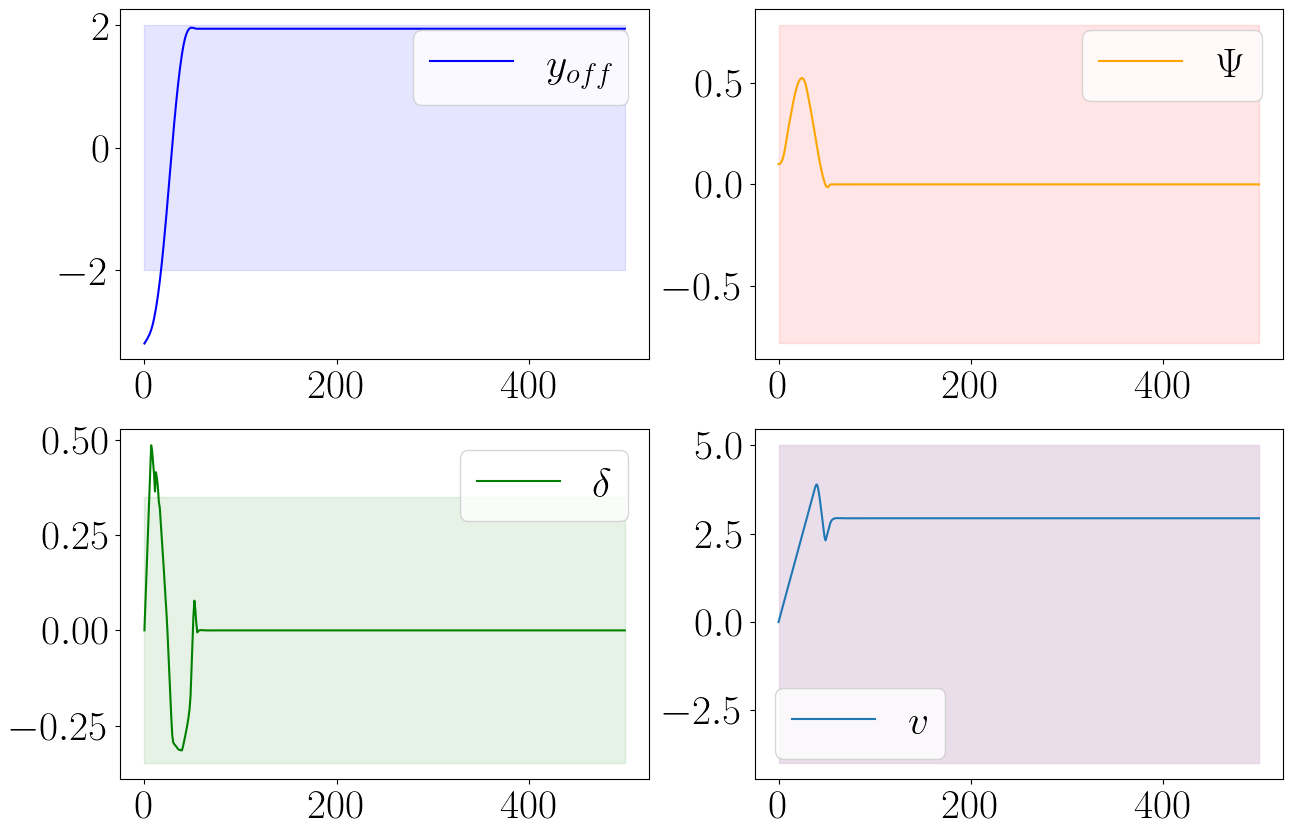

In [16]:
t = np.arange(N_steps+1)
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,x_safe[:,0], label = '$y_{off}$', color='blue')
axs[0][1].plot(t,x_safe[:,1], label = '$\Psi$', color='orange')
axs[1][0].plot(t,x_safe[:,2], label = '$\delta$', color='green')
axs[1][1].plot(t,x_safe[:,3], label = '$v$')

y = np.zeros_like(t)
axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='b', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='red', alpha=.1)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)   

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

### Maximum approximate decrease rate - Multiple initial conditions simulation

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

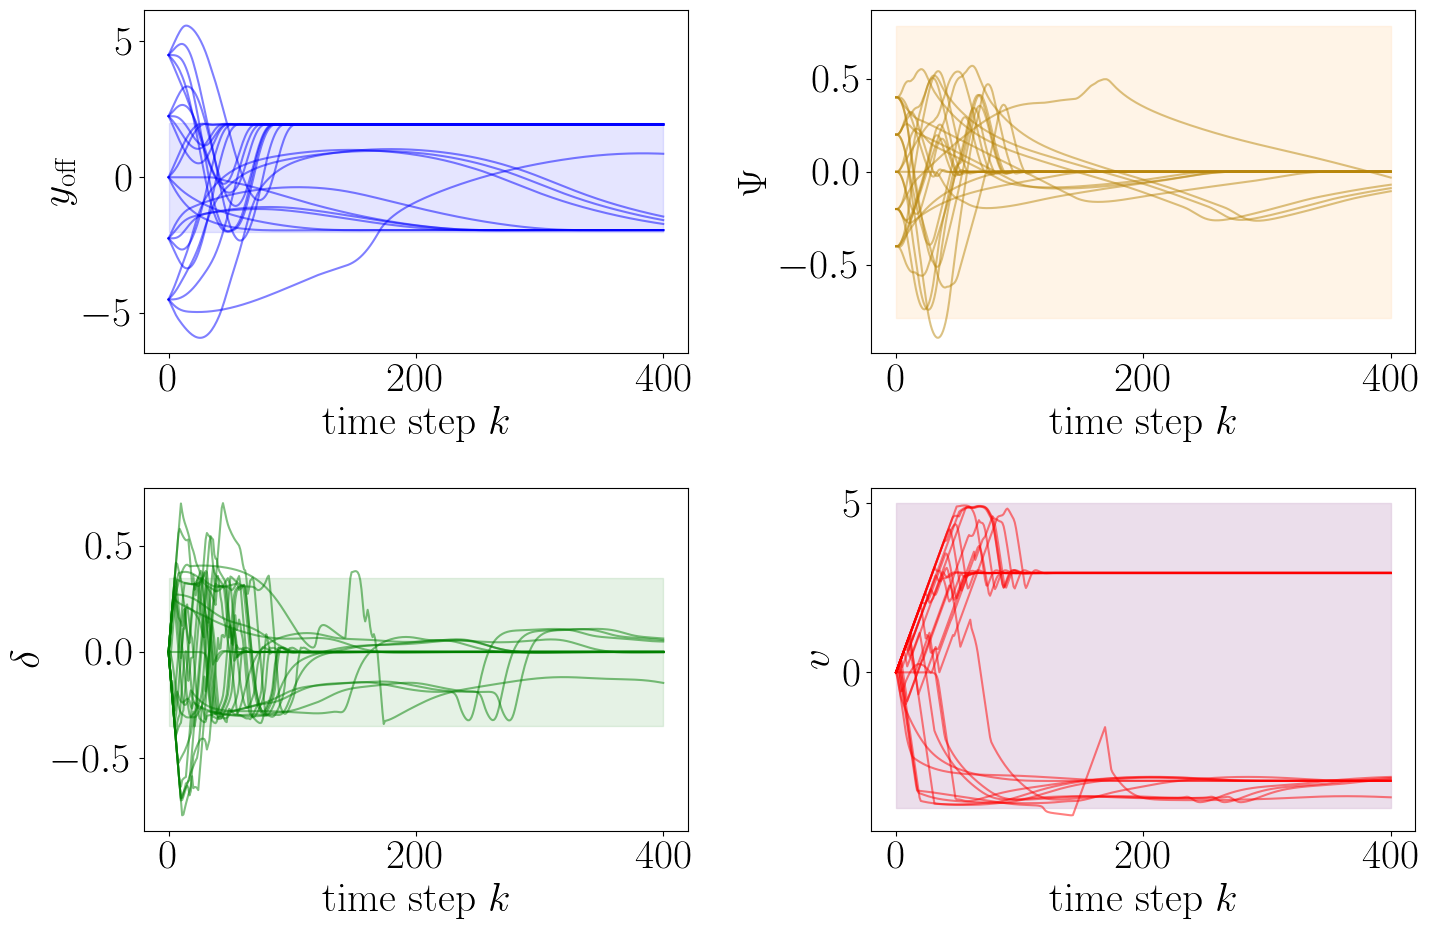

In [17]:
#%matplotlib widget
n_points = 5
x1 = np.linspace(-4.5,4.5,n_points) # y_off
x2 = np.linspace(-0.4,0.4,n_points) # Psi
x1,x2 = np.meshgrid(x1,x2)
hpb = np.zeros((len(x1), len(x2)))
algo = learned_controller_maxdec
algo.hpb_traj = []
numb_infeasible = 0
failure_pts = []
h_traj = []
pt_name_str = []
pts = []
x_states_traj_list = []

Nsteps = 400 # Number of simulation time steps

t = np.arange(Nsteps+1)
y = np.zeros_like(t)
fig, axs = plt.subplots(2,2)

axs[0, 0].set(ylabel = '$y_{\mathrm{off}}$')
axs[0, 1].set(ylabel = '$\Psi$')
axs[1, 0].set(ylabel = '$\delta$')
axs[1, 1].set(ylabel = '$v$')

axs[0, 0].set(xlabel = 'time step $k$')
axs[0, 1].set(xlabel = 'time step $k$')
axs[1, 0].set(xlabel = 'time step $k$')
axs[1, 1].set(xlabel = 'time step $k$')


axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='bisque', alpha=.4)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)  

x_plot = []
u_plot = []

# Iterate over grid points
for j in trange(len(x1)):
    for k in trange(len(x2), leave=False):
        try :
            x_safe, u_safe = sim.simulate_discrete(np.array([x1[j,k], x2[j,k], 0, 0]), non_lin_disc, controller_object=algo, Nsteps=Nsteps, verbose=False)
            
            
            x_plot.append(x_safe)
            u_plot.append(u_safe)
            
            pt_name_str.append(str(np.array([x1[j,k], x2[j,k], 0, 0])))
            pts.append(np.array([x1[j,k], x2[j,k], 0, 0]))
            h_traj.append(algo.hpb_traj)
            algo.hpb_traj = []
            x_states_traj_list.append(x_safe)
            #algo.reset()
        except Exception as e:
            print(e)
            #algo.reset()
            numb_infeasible += 1
            x_failure = x1[j,k], x2[j,k]
            #print(x1[j,k], x2[j,k])
            failure_pts.append(np.array([x1[j,k], x2[j,k]])) 

if numb_infeasible > 0 :
    print(f"Number of infeasible/failure points : {numb_infeasible}")

for i in range(len(x_plot)):
    axs[0][0].plot(t,x_plot[i][:,0], label = '$y_{\mathrm{off}}$', color='blue', alpha=.5)
    axs[0][1].plot(t,x_plot[i][:,1], label = '$\Psi$', color='darkgoldenrod', alpha=.5)
    axs[1][0].plot(t,x_plot[i][:,2], label = '$\delta$', color='green', alpha=.5)
    axs[1][1].plot(t,x_plot[i][:,3], label = '$v$',  color='red', alpha=.5)
    
plt.tight_layout()
#plt.savefig(f'plots/pdf/nonlin_{str(algo)}_trajectories__nonlinear_approx_box2_{Nsteps}steps_{LOG_NAME}_{n_points}pts.pdf', bbox_inches='tight')

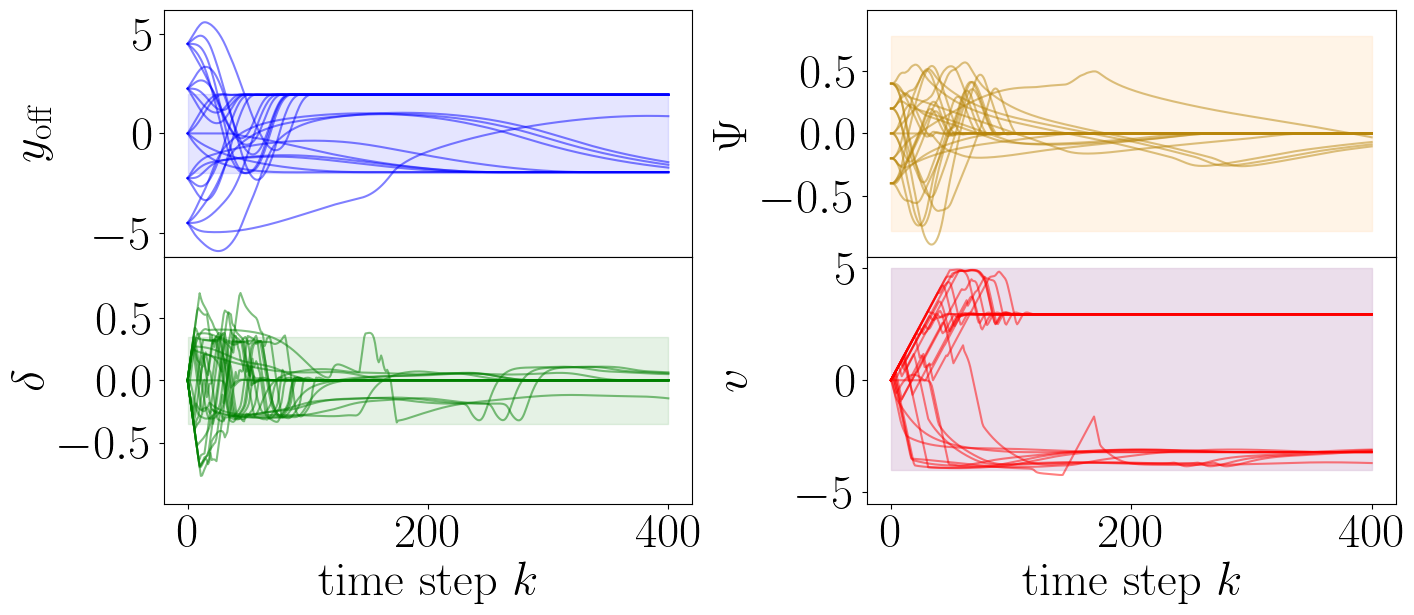

In [33]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 35})
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = [15, 7]

t = np.arange(Nsteps+1)
y = np.zeros_like(t)
fig, axs = plt.subplots(2,2)
axs[0, 0].set(ylabel = '$y_{\mathrm{off}}$')
axs[0, 1].set(ylabel = '$\Psi$')
axs[1, 0].set(ylabel = '$\delta$')
axs[1, 1].set(ylabel = '$v$')

axs[1, 0].set(xlabel = 'time step $k$')
axs[1, 1].set(xlabel = 'time step $k$')

axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='bisque', alpha=.4)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)     

for i in range(len(x_plot)):
    axs[0][0].plot(t,x_plot[i][:,0], label = '$y_{\mathrm{off}}$', color='blue', alpha=.5)
    axs[0][1].plot(t,x_plot[i][:,1], label = '$\Psi$', color='darkgoldenrod', alpha=.5)
    axs[1][0].plot(t,x_plot[i][:,2], label = '$\delta$', color='green', alpha=.5)
    axs[1][1].plot(t,x_plot[i][:,3], label = '$v$',  color='red', alpha=.5)

axs[0, 0].set_ylim([-6.2, 6.2])
axs[0, 1].set_ylim([-0.99, 0.99])
axs[1, 0].set_ylim([-0.99, 0.99])
axs[1, 1].set_ylim([-5.5, 5.5])


axs[0, 0].tick_params(axis='x', bottom=False, labelbottom=False)
axs[0, 1].tick_params(axis='x', bottom=False, labelbottom=False)

fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.33)
plt.savefig(f'../plots/pdf/nonlin_APCBF_SF_MAXDEC_{Nsteps}steps.pdf', bbox_inches='tight')

In [ ]:
# Solve true CBF values along trajectories
h_true_list = []
pcbf = SlackOpt(non_lin_cont, X, U, delta_i, params_dict, N=50, verbose=False)
for x_traj in tqdm(x_states_traj_list) :
    h_true = []
    for x in x_traj :
        _, _ , h_temp, u_traj, _ = pcbf.solve(x)
        h_true.append(h_temp)
    h_true_list.append(h_true[:-1])

In [ ]:
h_true_list_np = np.array(h_true_list)
h_true_list_np[:,-100:].max()

In [ ]:
# Plot true vs learned CBF values along trajectories
h_traj = np.array(h_traj)
for idx, (h, pt) in enumerate(zip(h_traj, pt_name_str)) :
    p = plt.plot(h, label='$\hat{h}_{PB}$' if idx == 0 else '')
    plt.plot(h_true_list[idx], '--', label='${h}_{PB}$' if idx == 0 else '', color = p[-1].get_color())
#plt.plot(h_traj[10])
plt.ylabel('$h_{\mathrm{PB}}(k)$')
plt.xlabel('time step $k$')
#plt.legend(loc=(1.04,0))
plt.legend()
#plt.savefig(f'plots/pdf/nonlinear_{str(algo)}_traj_learned_sf_{LOG_NAME}_hbpvstrue_{n_points}pts_latex.pdf', bbox_inches = 'tight')

# Class $\mathcal{K}_{\infty}$ function for the decrease rate \$\Delta h_{\mathrm{PB}}$

Set $\Delta h_{\mathrm{PB}} = \alpha(x(k))$ where $\alpha$ is a class $\mathcal{K}_{\infty}$ function.


\begin{equation} \min_{u, \xi} || u - u_p|| + \alpha_\xi\xi  \\ \text{subj.} \hat{h}(x^+) - \hat{h}(x) \leq -\Delta h_{\mathrm{PB}}+ \delta_{tol} + \xi\\ \end{equation}

In this example we set $\alpha(r) = c_{\alpha}\cdot r$ with $c_{\alpha} = 0.5$

Stand alone implementation can be found in `apcbf/approximate_sf_nonlinear.py`

In [19]:
learned_controller_kinf = APCBFSafetyFilterKINFDEC(model = model,m_type = model_type_name, use_log_space_model=use_log_space_model, 
                                                   use_plus_model = use_plus_models, params_dict = params_dict, sys= sys, input_constraints = U, 
                                                   performance_controller = bad_ctrl, verbose = False)

In [20]:
u_test = learned_controller_kinf.input(np.array([.3,.2, .2,.3]).reshape(4,1))
u_test

array([1.39626327, 1.99999986])

### Approach 2 - Single Trajectory Simulation

In [21]:
# initial condition
#x0 = np.array([-0.1,3])
x0 = np.array([2.3, 0.0, 0.40, 0])
#x0 = np.array([0.2,1.5])
#x0 = np.array([-12.0, 3.46153846])
N_steps = 400

In [22]:
x_safe, u_sim = sim.simulate_discrete(x0, sys, controller_object=learned_controller_kinf, Nsteps=N_steps)

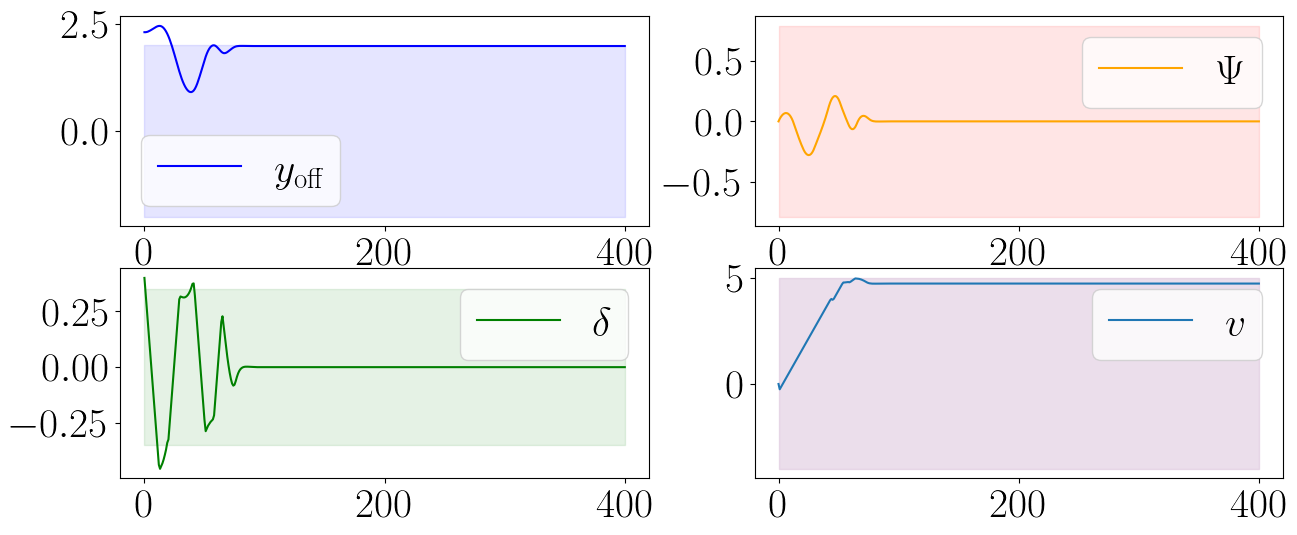

In [23]:
t = np.arange(N_steps+1)
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,x_safe[:,0], label = '$y_{\mathrm{off}}$', color='blue')
axs[0][1].plot(t,x_safe[:,1], label = '$\Psi$', color='orange')
axs[1][0].plot(t,x_safe[:,2], label = '$\delta$', color='green')
axs[1][1].plot(t,x_safe[:,3], label = '$v$')

y = np.zeros_like(t)
axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='b', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='red', alpha=.1)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)   


axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

### Approach 2 - Multiple ICs Simulation

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

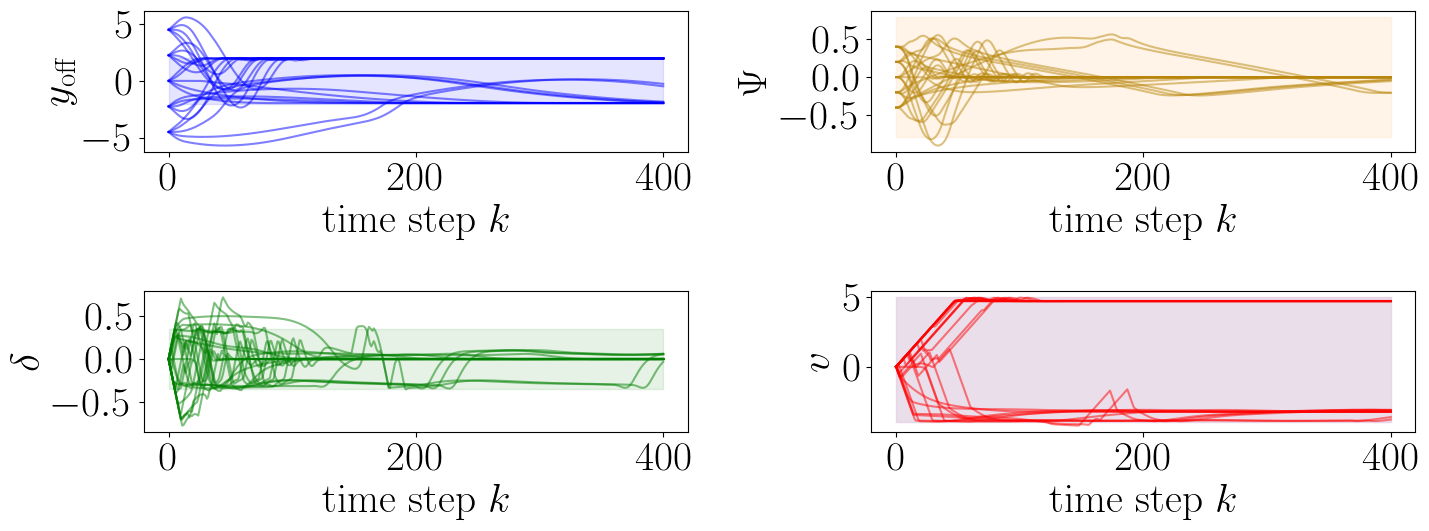

In [26]:
from tqdm.notebook import tqdm
#%matplotlib widget
n_points = 5

#x1 = np.linspace(-2.5,2.5,n_points) #y_off
x1 = np.linspace(-4.5,4.5,n_points) 
x2 = np.linspace(-0.4,0.4,n_points) #Psi
x1,x2 = np.meshgrid(x1,x2)
hpb = np.zeros((len(x1), len(x2)))
algo = learned_controller_kinf

algo.hpb_traj = []
numb_infeasible = 0
failure_pts = []
h_traj = []
pt_name_str = []
pts = []
x_states_traj_list = []

Nsteps = 400 # Number of Simulation time steps

t = np.arange(Nsteps+1)
y = np.zeros_like(t)
fig, axs = plt.subplots(2,2)

axs[0, 0].set(ylabel = '$y_{\mathrm{off}}$')
axs[0, 1].set(ylabel = '$\Psi$')
axs[1, 0].set(ylabel = '$\delta$')
axs[1, 1].set(ylabel = '$v$')

axs[0, 0].set(xlabel = 'time step $k$')
axs[0, 1].set(xlabel = 'time step $k$')
axs[1, 0].set(xlabel = 'time step $k$')
axs[1, 1].set(xlabel = 'time step $k$')

axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='bisque', alpha=.4)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)  

x_plot_k = []
u_plot_k = []

# Iterate over grid points
for j in trange(len(x1)):
    for k in trange(len(x2), leave = False):
        try :
            x_safe, u_safe = sim.simulate_discrete(np.array([x1[j,k], x2[j,k], 0, 0]), non_lin_disc, controller_object=algo, Nsteps=Nsteps, verbose=False)
            #axs[0][0].plot(t,x_safe[:,0], label = '$y_{\mathrm{off}}$', color='blue', alpha=.5)
            #axs[0][1].plot(t,x_safe[:,1], label = '$\Psi$', color='darkgoldenrod', alpha=.5)
            #axs[1][0].plot(t,x_safe[:,2], label = '$\delta$', color='green', alpha=.5)
            #axs[1][1].plot(t,x_safe[:,3], label = '$v$',  color='red', alpha=.5)
            
            x_plot_k.append(x_safe)
            u_plot_k.append(u_safe)
            
            #hpb[j,k] = algo.hpb_traj[0]
            pt_name_str.append(str(np.array([x1[j,k], x2[j,k], 0, 0])))
            pts.append(np.array([x1[j,k], x2[j,k], 0, 0]))
            h_traj.append(algo.hpb_traj)
            algo.hpb_traj = []
            x_states_traj_list.append(x_safe)
            #algo.reset()
        except Exception as e:
            print(e)
            #algo.reset()
            numb_infeasible += 1
            x_failure = x1[j,k], x2[j,k]
            print(x1[j,k], x2[j,k])
            failure_pts.append(np.array([x1[j,k], x2[j,k]])) 

if numb_infeasible > 0 :
    print(f"Number of infeasible/failure points : {numb_infeasible}")
    
for i in range(len(x_plot_k)):
    axs[0][0].plot(t,x_plot_k[i][:,0], label = '$y_{\mathrm{off}}$', color='blue', alpha=.5)
    axs[0][1].plot(t,x_plot_k[i][:,1], label = '$\Psi$', color='darkgoldenrod', alpha=.5)
    axs[1][0].plot(t,x_plot_k[i][:,2], label = '$\delta$', color='green', alpha=.5)
    axs[1][1].plot(t,x_plot_k[i][:,3], label = '$v$',  color='red', alpha=.5)
    
plt.tight_layout()
#plt.savefig(f'plots/pdf/xnonlin_{str(algo)}_trajectories__nonlinear_approx_box2_{Nsteps}steps_{LOG_NAME}_{n_points}pts.pdf', bbox_inches='tight')

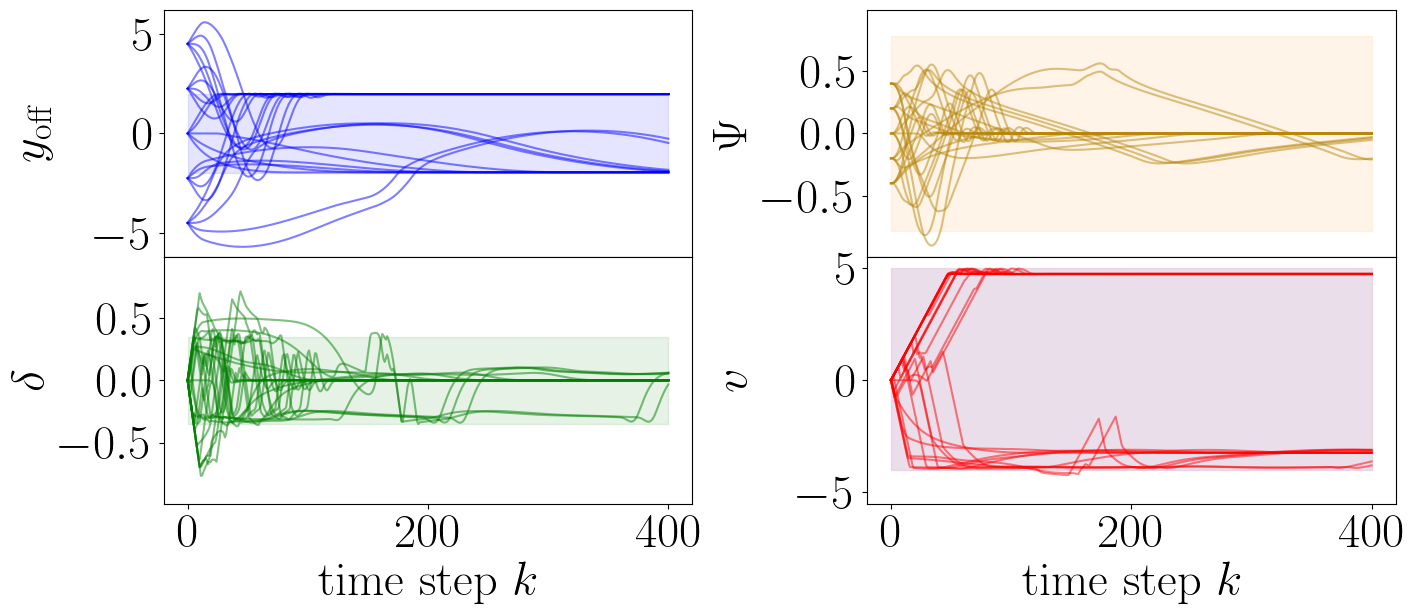

In [34]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 35})
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = [15, 7]

t = np.arange(Nsteps+1)
y = np.zeros_like(t)
fig, axs = plt.subplots(2,2)
axs[0, 0].set(ylabel = '$y_{\mathrm{off}}$')
axs[0, 1].set(ylabel = '$\Psi$')
axs[1, 0].set(ylabel = '$\delta$')
axs[1, 1].set(ylabel = '$v$')

axs[0, 0].set(xlabel = 'time step $k$')
axs[0, 1].set(xlabel = 'time step $k$')
axs[1, 0].set(xlabel = 'time step $k$')
axs[1, 1].set(xlabel = 'time step $k$')

axs[0, 0].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
axs[0, 1].fill_between(t, (y-X.b[3]), (y+X.b[2]), color='bisque', alpha=.4)
axs[1, 0].fill_between(t, (y-X.b[5]), (y+X.b[4]), color='green', alpha=.1)
axs[1, 1].fill_between(t, (y-X.b[7]), (y+X.b[6]), color='thistle', alpha=.5)     

for i in range(len(x_plot)):
    axs[0][0].plot(t,x_plot_k[i][:,0], label = '$y_{\mathrm{off}}$', color='blue', alpha=.5)
    axs[0][1].plot(t,x_plot_k[i][:,1], label = '$\Psi$', color='darkgoldenrod', alpha=.5)
    axs[1][0].plot(t,x_plot_k[i][:,2], label = '$\delta$', color='green', alpha=.5)
    axs[1][1].plot(t,x_plot_k[i][:,3], label = '$v$',  color='red', alpha=.5)

axs[0, 0].set_ylim([-6.2, 6.2])
axs[0, 1].set_ylim([-0.99, 0.99])
axs[1, 0].set_ylim([-0.99, 0.99])
axs[1, 1].set_ylim([-5.5, 5.5])


axs[0, 0].tick_params(axis='x', bottom=False, labelbottom=False)
axs[0, 1].tick_params(axis='x', bottom=False, labelbottom=False)

fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.33)

plt.savefig(f'../plots/pdf/nonlin_APCBF_SF_KINFDEC_{Nsteps}steps.pdf', bbox_inches='tight')

In [ ]:
# Compute true CBF along trajectory
h_true_list = []
pcbf = SlackOpt(non_lin_cont, X, U, delta_i, params_dict, N=50, verbose=False)
for x_traj in tqdm(x_states_traj_list) :
    h_true = []
    for x in x_traj :
        _, _ , h_temp, u_traj, _ = pcbf.solve(x)
        h_true.append(h_temp)
    h_true_list.append(h_true[:-1])

In [ ]:
h_true_list_np = np.array(h_true_list)
h_true_list_np[:,-100:].max()

In [ ]:
h_traj = np.array(h_traj)
for idx, (h, pt) in enumerate(zip(h_traj, pt_name_str)) :
    p = plt.plot(h, label='$\hat{h}_{PB}$' if idx == 0 else '')
    plt.plot(h_true_list[idx], '--', label='${h}_{PB}$' if idx == 0 else '', color = p[-1].get_color())
#plt.plot(h_traj[10])
plt.ylabel('$h_{PB}(k)$')
plt.xlabel('time step $k$')
#plt.legend(loc=(1.04,0))
plt.legend()
#plt.savefig(f'plots/pdf/nonlinear_{str(algo)}_traj_learned_sf_{LOG_NAME}_hbpvstrue_{n_points}pts_latex.pdf', bbox_inches = 'tight')